<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/linearModels_FFTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression and FFTs

Recall regression through the origin. If $y$ and $x$ are $n$-vectors of the same length, the minimizer of

$$
||y - \beta x ||^2
$$

is $\hat \beta = <x, y> / ||x||^2$. Note, if $||x|| = 1$ then the estimate is just $\hat \beta = <x, y>$. Now consider a second variable, $w$, such that $<x, w> = 0$ and $||w|| = 1$. Consider now the least squares model

$$
||y - \beta x - \gamma w||^2.
$$

We argued that the best estimate for $\beta$ now first gets rid of $w$ be regressing it out of $y$ and $x$. So, consider that

$$
||y - <w, y> w - \beta (x - <w, x> w)||^2 =
||y - <w, y> w - \beta x||^2. 
$$

Thus, now the best estimate of $\beta$ is

$$
<y - <w, y> w, x> = <y, x>.
$$

Or, in other words, if $x$ and $w$ are orthogonal then the coefficient estimate for $x$ with $w$ included is the same as the coefficient of $x$ by itself. This extends to more than two regressors. 

If you have a collection of $n$ mutually orthogonal vectors of norm one, they are called an orthonormal basis. For an orthonomal basis, 1. the coefficients are just the inner products between the regressors and the outcome and 2. inclusion or exclusion of other elemenents of the basis doesn't change a basis elements estimated coefficients.

It's important to note, that this works quite generally. For example, for complex numbers as well as real. So, for example, consider the possibility that $x$ is $e^{-2\pi i m k / n}$ for $m=0,\ldots, n-1$ for a particular value of $k$. Vectors like this are orthogonal for different values of $k$ and all have norm 1. We have already seen that the Fourier coefficient is 

$$
f_k = <y, x> = \sum_{m=0}^{n-1} y_m e^{-2\pi i m k / n} = 
\sum_{m=0}^{n-1} y_m \cos(-2\pi m k / n) + i \sum_{m=0}^{n-1} y_m \sin(-2\pi m k / n) 
$$

where $y_m$ is element $m$ of $y$. Thus, the Fourier coefficients are exactly just least squares coefficients applied in the complex space.  Thus we have that 

$$
f_k = a_k + i b_k
$$

where $a_k$ and $b_k$ are the coefficients from linear models with just the sine and cosine terms. Of course, we don't actually fit Fourier transforms this way, since there's a much faster way to do, aptly named the fast Fourier transform (FFT). However, knowing how fast discrete Fourier transforms relate to linear models allows us to use them in creative ways, like putting them into models with other covariates, or in logistic regression models.

Let's numerically look at FFTs and linear models using covid case counts in Italy as an example.


In [15]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [16]:
dat = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dat.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/13/21,9/14/21,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,154094,154180,154283,154361,154487,154487,154487,154585,154712,154757
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,157436,158431,159423,160365,161324,162173,162953,163404,164276,165096
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,200301,200528,200770,200989,201224,201425,201600,201766,201948,202122
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15096,15099,15108,15113,15124,15124,15124,15140,15140,15153
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,50738,51047,51407,51827,52208,52307,52307,52644,52968,53387


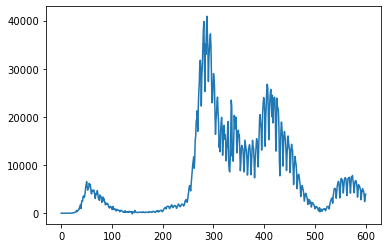

In [17]:
## Get Italy, drop everyrthing except dates, convert to long (unstack converts to tuple)
y=dat[dat['Country/Region'] == 'Italy'].drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1).unstack()
## convert from tuple to array
y = np.asarray(y)  
## get case counts instead of cumulative counts
y = y[1 : y.size] - y[0 : (y.size - 1)]
## get the first non zero entry
y =  y[np.min(np.where(y !=  0)) : y.size]
plt.plot(y)



Let's look at a smoothed version of it and then take the residual. The residual is where we'd like to look at some oscillatory behavior.

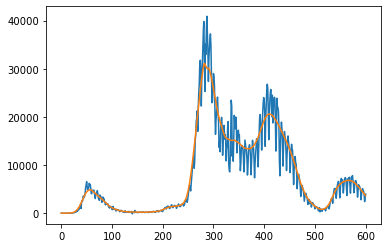

In [18]:
n = y.size
t = np.arange(0, n, 1)
lowess = sm.nonparametric.lowess
yhat = lowess(y, t, frac=.05,return_sorted=False)
plt.plot(y)
plt.plot(yhat)


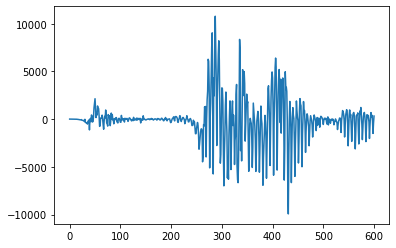

In [19]:
## We're interested in the residual
e = y - yhat
plt.plot(e)

Let's manually create our Fourier bases. We're just going to pick some periods to investigate. We'll pick a fast varying and slow varying.

In [20]:

## Create 4 elements
## Orthonormal basis (note dividing by sqrt(n/2) makes them norm 1)
c5  = np.cos(-2 * np.pi * t * 5 / n  ) / np.sqrt(n /2)
c20 = np.cos(-2 * np.pi * t * 20 / n ) / np.sqrt(n /2)
s5  = np.sin(-2 * np.pi * t * 5  / n  )/ np.sqrt(n /2)
s20 = np.sin(-2 * np.pi * t * 20 / n  ) / np.sqrt(n /2)

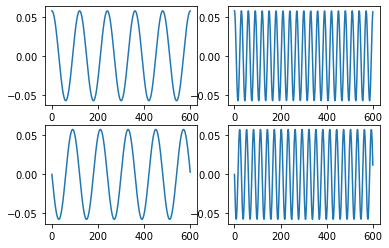

In [21]:
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(t, c5)
axs[0,1].plot(t, c20)
axs[1,0].plot(t, s5)
axs[1,1].plot(t, s20)
plt.show()

Let's verify that they are indeed orthonormal. That is, we want to show that $<x_i, x_j> = I(i =j)$. We also show that they are all mean 0.

In [29]:
## Verify that they are orthonormal mean 0, round to 6 decimal places
np.around( [
 np.sum(c5),
 np.sum(c20),
 np.sum(s5),
 np.sum(s20),
 np.sum(c5 * c5),
 np.sum(c20 * c20),
 np.sum(s5 * s5),
 np.sum(s20 * s20),
 np.sum(c5 * s5),
 np.sum(c5 * s20),
 np.sum(c5 * c20),
 np.sum(s5 * s20),
], 6)

array([-0., -0.,  0., -0.,  1.,  1.,  1.,  1., -0.,  0., -0.,  0.])

Let's take the FFT, the fast (discrete) Fourier transform th way one would normally do it. First, we use FFT in numpy. Then, there's a convenient method, `fftfreq`, which gives the associated frequencies with each element of the transform. Finally, we plot the spectral density, which is the sum of the real and complex Fourier coefficients. Sorting the elements first is necessary to connect the dots on the plot. Interestingly, once we remove the trend from the Italy data, there's some very noticeable spikes in the spectral density, which implies large coefficients on that specific frequency. This is possibly some reporting issue.

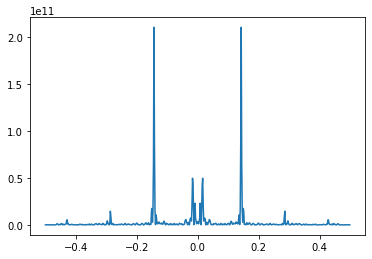

In [30]:
f = np.fft.fft(e)
w = np.fft.fftfreq(n)
ind = w.argsort()
f = f[ind] 
w = w[ind]
plt.plot(w, f.real**2 + f.imag**2)

Now let's manually find the coefficients using our constructed bases and the formula that the coefficients.

In [31]:
[
 np.sum(c5 * e) * np.sqrt(n / 2),
 np.sum(c20 * e) * np.sqrt(n / 2),
 np.sum(s5 * e) * np.sqrt(n / 2),
 np.sum(s20 * e) * np.sqrt(n / 2),
] 

[-122321.23192612399,
 -19854.09302843738,
 -90543.46016843051,
 -5434.237738349892]

In [167]:
sreg = linear_model.LinearRegression()
x=np.c_[c5, c20, s5, s20]
fit = sreg.fit(x, y)
fit.coef_ * np.sqrt(n/2)


array([ 7023.06387147,  3129.66692969, -2734.54157365, -1381.53286565])

In [168]:
x=np.c_[c5, s5]
fit = sreg.fit(x, y)
fit.coef_ * np.sqrt(n/2)


array([ 7023.06387147, -2734.54157365])

In [169]:
test = np.where( np.abs(f.real / np.sum(c5 * y) / np.sqrt(n / 2) - 1) < 1e-5) 
[test, f.real[test], w[test], 5 / n]

[(array([115, 125]),),
 array([7023.06387147, 7023.06387147]),
 array([-0.02074689,  0.02074689]),
 0.02074688796680498]

In [170]:
f.imag[test]

array([ 2734.54157365, -2734.54157365])